# CMU Machine Learning with Large Datasets

## Homework 3 - Coding 1: LSH for Image Data


Before you turn these assignments in, make sure everything runs as expected. Be sure to click **Run all** (in the upper right).

Follow the guide and fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."


In [88]:
# Who did you collaborate with on this assignment?
# if no one, collaborators should contain an empty string,
# else list your collaborators below

collaborators = []

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

# **Approximate Nearest Neighbors Search and LSH**


Nearest neighbor (NN) search is an important concept in Machine Learning as it arises in numerous applications such as reverse image search, semantic search, or genome sequencing. Formally, given a set of points $X\subset\mathbb{R}^d$ and a query point $q\in \mathbb{R}^d$, the goal of NN search is to find the closest point(s) in $X$ to $q$. Defining "nearest" is perhaps the most important aspect of a NN algorithm, however, in practice we tend to use euclidean distance. This can be problematic in very high-dimensional spaces, which is why typically the data is first reduced via PCA or other feature representation models such as deep neural networks.

Another challenge of the standard, exact NN algorithm is its runtime complexity. For a single query point, NN has a running time of $O(|X|\cdot d)$. In practice, we commonly compute a nearest neighbors graph which requires computing all pairs of distances for a total running time of $O(|X|^2\cdot d)$, which can be prohibitive for very large datasets.

For this reason, approximate nearest neighbor (ANN) algorithms have found an increase in popularity. The goal of an ANN algorithm is to return neighbors whose distance from the query point is no larger than some constant $c$ times the distance from the true nearest points, while consuming less memory and making faster inferences.

In this homework, we will explore a variant of ANN search for images based on locality-sensitive hashing (LSH). As discussed in class, LSH consists of a hashing function which encourages collisions between nearby points in the original space. Choosing the right hashing function is somewhat of an art and depends largely on the domain. In this assignment, we will develop the **cross-polytope hash** ([ref](https://people.csail.mit.edu/ludwigs/papers/nips15_crosspolytopelsh.pdf)) for image data. Roughly, the hash first projects an input sample to a lower dimensional space (by using a random linear projection) and then selects the coordinate with the highest magnitude in the resulting projected vector. The _index_ of this coordinate, along with its sign, serves as a hash for the given input. One could then perform multiple such projections and stack all the individual hash values to form a _fingerprint_. The number of projections and their dimensionality is a hyperparameter that we need to tune. Increasing the number of dimensions tends to lead to fewer collisions.

This variant of LSH is fast (runtime is dominated by the projection step) and easy to implement. Our goal is to explore its performance on images.

### Table of Contents

- **0. Preliminaries**
- **0.1 Load the Data**

- **1. Data Exploration**
- **1.1 Display Random Images**
- **1.2 Compute Statistics about the Data**
- **2. Implementing LSH**
- **2.1 Write Code to Generate Random Linear Maps**
- **2.2 Implement the Hashing Function**
- **2.3 Implement the Fingerprint Function**
- **3. Processing**
- **3.1 Compute Fingerprints for the Given Dataset**
- **3.2 Distribute Images into Buckets**
- **3.3 Plot Bucket Sizes**
- **3.4 Filter Buckets with at least Two Elements**
- **4. Analysis and Visualization**
- **4.1 Write Code to Map a Query Image to its Neighbors**
- **4.2 Visualize LSH Neighbors**
- **5. Feature Extraction Using a Pre-Trained VGG**
- **5.1 Compute Neighbors based on VGG Embeddings**
- **5.2 Compare VGG Neighbors to LSH Neighbors**


Some links:

- **RDD API**: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html
- **Cross-polytope** hash: https://people.csail.mit.edu/ludwigs/papers/nips15_crosspolytopelsh.pdf
- **Caltech 101 dataset**: https://www.tensorflow.org/datasets/catalog/caltech101
- **The S3 bucket containing the data**: https://us-east-1.console.aws.amazon.com/s3/buckets/10-605spring2025?region=us-east-1&bucketType=general&prefix=101_ObjectCategories/&showversions=false

This homework can be solved by using RDD function calls only, but if you need to, you can also use DataFrames

- **DataFrame API** https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html


In [90]:
import math
import os
import pickle
from itertools import islice, zip_longest

import matplotlib.pyplot as plt
import numpy as np
import pyspark
from nose.tools import assert_equal, assert_true
from PIL import Image
from pyspark.sql import Row
from pyspark.sql.types import *

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 0. Preliminaries


For this assignment, we will be using the [Caltech-101 dataset](https://www.tensorflow.org/datasets/catalog/caltech101). Caltech-101 contains 102 (colored) image classes, where one of them is a background clutter class. The images are of varying sizes, so we need to resize them to the same shape first.


In [91]:
SHAPE = (64, 64, 3)  # shape used for plotting figures
FP_SHAPE = (8, 8, 3)  # shape used for computing the fingerprint

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 0.1 Load the data


We provide a few helper functions that preprocess each image and return a Row containing _label_, _filename_, and two arrays with image data. _image_ is the array we will use to perform our projections and compute the fingerprints, and the other, larger array _image_lg_ will be used for plotting only.

We perform the following preprocessing steps:

1. Convert binary data to a numpy array containing pixel values.
2. Convert to RGB in case the image is grayscale or contains an extra alpha channel.
3. Resize the image.
4. Convert from BGR to RGB.
5. Flatten the image vectors.
6. Add an index to each row as an identifier.


In [92]:
# Doc: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes

channels_to_mode = {
    1: 'L',
    3: 'RGB',
    4: 'RGBA',
}


def bgr_to_rgb(img):
    """The image datasource built in spark uses opencv to load images
    and due to historical reasons, opencv loads the images in BGR format.
    Most other libraries, such as pillow or matplotlib assume an RGB format
    so we have to convert the format ourselves.

    Source: https://spark.apache.org/docs/latest/ml-datasource.html#image-data-source
    """
    B, G, R = img.T
    return np.array((R, G, B)).T


def resize_img(row):
    """Spark loads the images as a bytearray, so we need to convert it to a
    numpy array. Also, some images may contain an additional alpha channel,
    which we are not interested in, so we remove it. Finally we resize the image
    and convert the format from BGR to RGB.
    """
    mode = channels_to_mode[row.nChannels]
    # frombytes expects a bytes-like object not a bytearray, so we need to call `bytes`.
    img = Image.frombytes(mode=mode, data=bytes(row.data), size=(row.width, row.height))
    img = img.convert('RGB') if (mode != 'RGB') else img
    # We keep one high-res image for plotting
    # and a smaller version for LSH.
    img_lg = img.resize(SHAPE[:2])  # don't need channels for this func call
    img_fp = img.resize(FP_SHAPE[:2])
    img_arr = bgr_to_rgb(np.asarray(img_lg))
    img_arr_fp = bgr_to_rgb(np.asarray(img_fp))
    return img_arr.flatten(), img_arr_fp.flatten()  # flatten the images


def bytes_row_to_array_row(row):
    # Each row in the inner RDD is a Row(image=Row(data...)),
    # so we get rid of one unneccessary layer by mapping to row.image.
    row = row.image
    image_lg, image = resize_img(row)
    return Row(
        label=row.origin.rsplit('/', maxsplit=2)[-2],  # e.g., anchor
        filename='/'.join(row.origin.rsplit('/', maxsplit=2)[-2:]),  # e.g., anchor/image_0001.jpg
        image=image,
        image_lg=image_lg,
    )


def add_index_to_row(image_rdd):
    """When working with kNN, it is typically better to return
    indices of the neighbors rather than the full images themselves
    for efficiency. Here we add a unique index to each row.
    """
    rdd_with_zipped_idx = image_rdd.zipWithIndex()
    # This rdd consists of tuples in the format (row, idx).
    # For convenience, we convert to row(idx, data...).
    return rdd_with_zipped_idx.map(lambda x: Row(
        idx=x[1],
        **x[0].asDict(),
    ))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This public S3 bucket containing all the image files can be accessed here: https://us-east-1.console.aws.amazon.com/s3/buckets/10-605spring2025?region=us-east-1&bucketType=general&prefix=101_ObjectCategories/&showversions=false.

While setting up the EMR cluster we added a "Step" that copies the data from this bucket to your Hadoop filesystem (core nodes) under `/data`. See the recitation slide for more details: https://docs.google.com/presentation/d/11hTKXffZhdyMhDlTV6DrYBroX1mwt-q4/edit?usp=sharing&ouid=103341013185105748774&rtpof=true&sd=true.

**Make sure that your step finishes running before executing the following cell.** Go to your EMR console and click on `Steps`. The status of your step should be marked as `Completed`.


**Hint: Use a smaller data subset during development.** The spark `load` function supports pattern matching to read specific files from a directory.
Note that some cells (towards the end) will test your code on specific images which may or may not be in your sample. In the latter case, an exception will be raised.


In [93]:
# Since the data was moved to the hadoop filesystem,
# we can access it directly using spark.
image_rdd = spark.read.format("image").load("/data/*/*.jpg").rdd

# You can instead use a smaller subset of the data during development.
# E.g., pick only classes that start with an 'h'.

#image_rdd = spark.read.format("image").load("/data/s*/*.jpg").rdd

image_rdd = image_rdd.map(bytes_row_to_array_row)
image_rdd = add_index_to_row(image_rdd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 1. Data Exploration


### 1.1 Display Random Images


Let's first count the number of images in our dataset.


In [94]:
# Count the number of images
n_images = image_rdd.count()
print(f"Found {n_images} images.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found 9144 images.

Now we take a random sample of five images and display them to make sure we loaded them properly. Since we flattened the image vectors earlier, we need to reshape back to (W, H, 3). You will need the `%matplot plt` magic command if running on AWS notebooks. Put this _at the end_ of the cell. We also print the Row attributes for reference.


In [95]:
# Take a random sample of 5 images
example_rows = image_rdd.takeSample(withReplacement=False, num=5)
# Print the Row columns
print(f"Row attributes: {example_rows[0].__fields__}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row attributes: ['idx', 'label', 'filename', 'image', 'image_lg']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

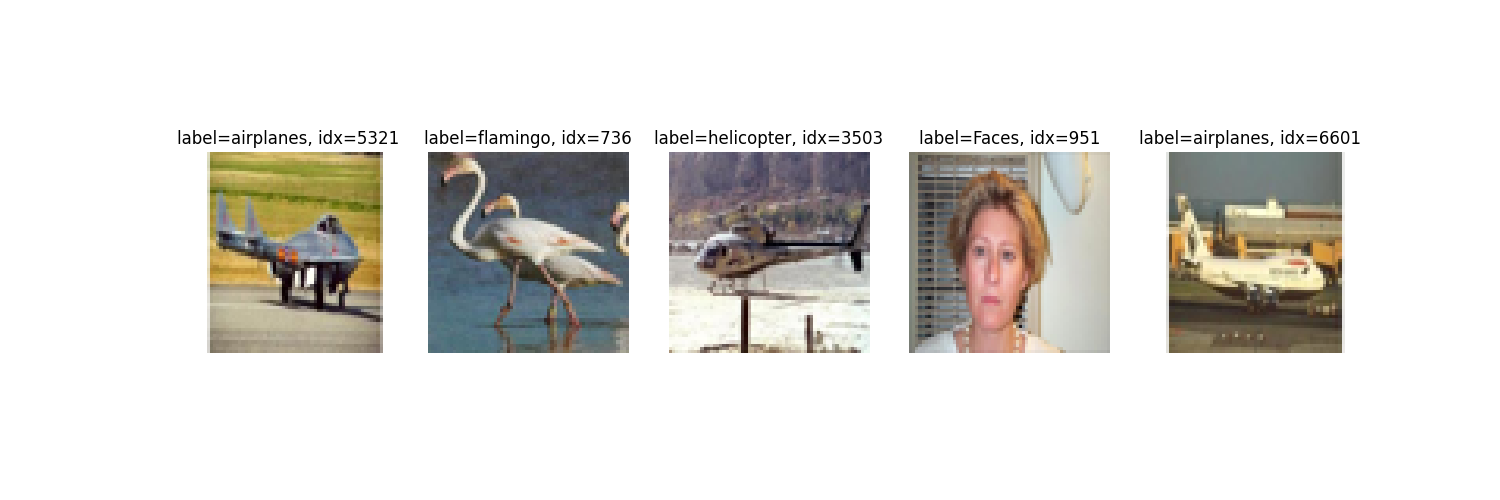

In [96]:
# Plot five images
fig, axes = plt.subplots(ncols=5, figsize=(15, 5))
for row, ax in zip(example_rows, axes.flat):
    ax.imshow(np.asarray(row.image_lg).reshape(SHAPE))
    ax.set_title(f"label={row.label}, idx={row.idx}")
    ax.set_axis_off()
plt.show()

%matplot plt

### 1.2 Compute Statistics about the Data


Your first task is to compute the number of images under each class (label). It is always a good idea to plot this distribution to see any class imbalances in the data.


In [97]:
def countLabels(image_rdd):
    """
    Count the occurrences of each label.

    Parameters
    ----------
    image_rdd : pyspark.RDD
        An RDD where each element is typically a tuple of the form (label, image_data).

    Returns
    -------
    dict
        A dictionary mapping each label to an integer count of how many images have that label.
    """
    # If each record is keyed by 'label', we can directly use countByKey()
    label_counts = image_rdd.countByKey()

    # countByKey() returns a collections.defaultdict, which typically behaves like a dict
    # Convert it explicitly to a normal dict if desired:
    return dict(label_counts)


label_counts = countLabels(image_rdd)
print(f"Found {len(label_counts)} classes.")
print(label_counts)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found 9144 classes.
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

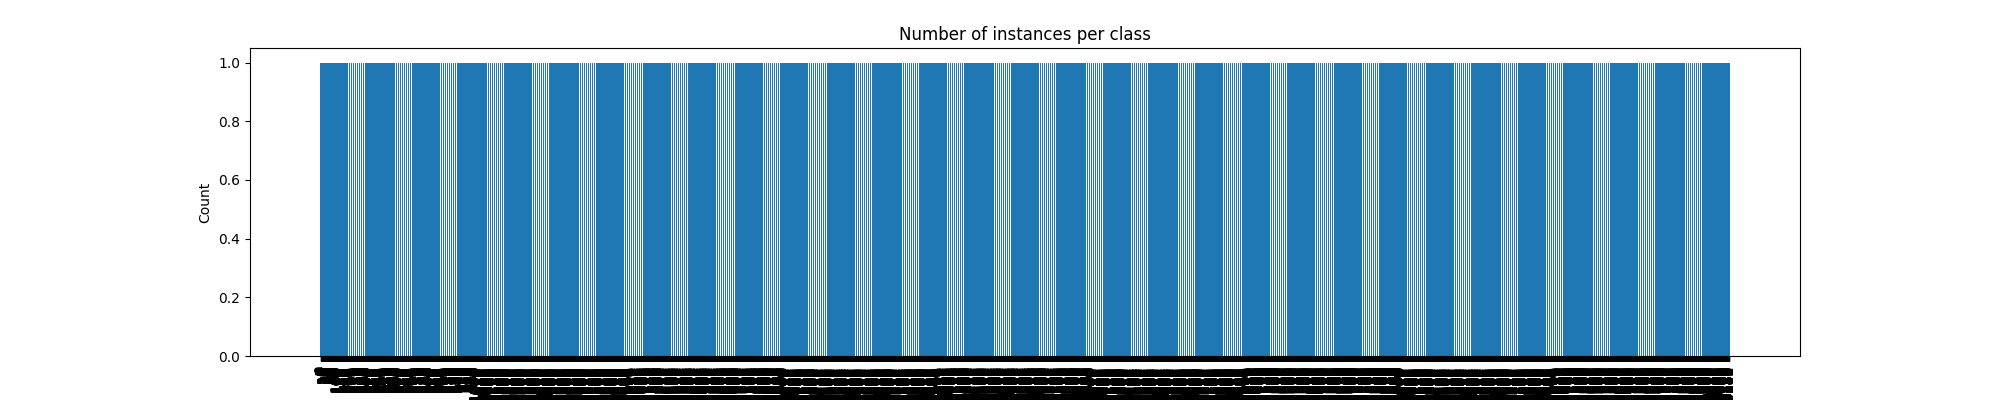

In [98]:
plt.clf()
fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(
    range(len(label_counts)),
    list(label_counts.values()),
    tick_label=list(label_counts.keys())
)
ax.tick_params('x', rotation=90)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Number of instances per class')
plt.show()

%matplot plt

## Part 2. Implementing LSH


Now let us describe the cross-polytope hash in more details.

Let $x\in\mathbb{R}^n$ be an n-dimensional vector (e.g., flattened image array). Let us also assume that we have a function $f: \mathbb{R}^n \to \mathbb{R}^d$ that maps $x$ to a new coordinate system (i.e., a lower dimensional representation) such that distances between points are (approximately) preserved. Denote $y = f(x)$ and let $i$ be the index corresponding the the coordinate of $y$ with the largest magnitude, i.e., $|y_i| \geq |y_j|, \forall j\neq i$. The hash of $x$ under the map $f$ is the pair $(i, \text{sign}(y_i))$. We can denote $\text{sign}(y_i)$ by `True` if it is non-negative, and `False` otherwise.

In the paper linked above, the authors find the closest point to $y$ from $\{\pm e_i\}_{1\leq i\leq d}$, where $e_i$ is the $i$-th standard basis vector of $\mathbb{R}^d$ and use that as a hash of $x$. But note that the two formulations are equivalent if $y$ has unit length.

We can pick $f$ to be a random linear map in Johnson-Lindenstrauss style. In this assignment, to construct such a map we sample from a standard normal $A_{ij}\sim\mathcal{N}(0, 1)$ and scale $A$ by the inverse of the square root of the dimension. You can read more about Johnson-Lindenstrauss projections [here](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma) if you are interested.

Finally, note that we can construct multiple projections and compute a hash for each one. This should (hopefully) lead to higher quality neighbors. We collect all these hashes into a single list and call this list the **fingerprint** of $x$.

**Example**

Let $y_1=[1, 2, -3]$ and $y_2=[5, 2, -1]$. Then $h_1=(2,\ \text{False})$ and $h_2=(0,\ \text{True})$. Finally, the fingerprint is $((2,\ \text{False}),\ (0,\ \text{True}))$.


### 2.1 Write Code to Generate Random Linear Maps


In the following function, `obj_dims` is a list containing the objective dimensions. These dimensions can take different values.

You can use `np.random.normal` to sample from a standard normal.


In [99]:
import numpy as np

def get_random_linear_maps(n_dims, obj_dims):
    """
    Parameters
    ----------
    n_dims: int
        Original number of dimensions in the data.
    obj_dims: List[int]
        List of integers corresponding to the
        objective dimensions of the random vectors.

    Returns
    -------
    random_maps: List[np.ndarray]
        List of random linear maps such that
        random_maps[i].shape[1] == obj_dims[i]. Each matrix row
        is scaled to have expected unit norm. That is, each matrix with
        column dimension d is scaled by 1/sqrt(d).
    """
    # Ensure each objective dimension is less than the original dimensions.
    for obj_dim in obj_dims:
        assert obj_dim < n_dims, "Objective dimension must be less than n_dims."

    random_maps = []

    for obj_dim in obj_dims:
        # Generate a random matrix with shape (n_dims, obj_dim)
        A = np.random.normal(0, 1, size=(n_dims, obj_dim))
        # Scale the matrix so that each row has expected unit norm.
        A_scaled = A / np.sqrt(obj_dim)
        random_maps.append(A_scaled)

    return random_maps


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
_random_maps = get_random_linear_maps(11, [3, 7])
# Check that the correct number of matrices is returned
assert_equal(len(_random_maps), 2)
# Check that the shapes of the random matrices are correct
assert_equal(_random_maps[0].shape, (11, 3))
assert_equal(_random_maps[1].shape, (11, 7))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.2 Implement the Hashing Function


The following function takes a single projection and compute the hash as explained above.


In [101]:
import numpy as np

def get_largest_coordinate(v):
    """
    Parameters
    ----------
    v: 1D list or array
        The input vector

    Returns
    -------
    tuple (int, bool)
        A tuple where the int corresponds to the index of the coordinate with the
        largest magnitude, and the bool is True if that coordinate is >= 0 and False otherwise.
    """
    # Convert the input to a numpy array (if it isn't one already)
    v = np.array(v)
    
    # Find the index of the coordinate with the largest absolute value.
    max_index = int(np.argmax(np.abs(v)))
    
    # Determine the sign and cast it to a native Python bool.
    sign_is_non_negative = bool(v[max_index] >= 0)
    
    return (max_index, sign_is_non_negative)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
_v = [-1, -2, 8, 5, -4]
# Check that we are returning int's and bool's
assert_true(isinstance(get_largest_coordinate(_v)[0], int))
assert_true(isinstance(get_largest_coordinate(_v)[1], bool))
# Check that the correct index is returned for positive coordinate
assert_equal(get_largest_coordinate(_v), (2, True))
_w = [-1, -2, 0, 5, -7]
# Check that the correct index is returned for negative coordinate
assert_equal(get_largest_coordinate(_w), (4, False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.3 Implement the Fingerprint Function


The following function takes a (flattened) image vector and a list of random linear projections which are used to compute the fingerprint for that input. You can call the previously defined function `get_largest_coordinate`. Make sure to return a tuple of tuples, since lists are not hashable in Python.


In [103]:
import numpy as np

def get_fingerprint(image, random_maps):
    """
    NOTE: It is important that we don't return a list
    but a tuple of tuples (or any other immutable
    data structure, so that we can hash it).

    Parameters
    ----------
    image: list
        Flattened image data.
    random_maps: list of arrays
        Each array is a random linear map for projecting the image.

    Returns
    -------
    tuple of tuples ((int, bool), ...)
        A tuple where each element is a tuple containing the index of the coordinate
        with the largest magnitude and a boolean indicating its sign (True for non-negative).
    """
    # Ensure the image is a NumPy array
    image = np.array(image)
    
    # For each random linear map, compute the projection and hash it.
    fingerprint = tuple(get_largest_coordinate(np.dot(image, random_map)) for random_map in random_maps)
    
    return fingerprint


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
# Check that fingerprints are computed properly
_image = [2, -4, -5]
_map = [[1, 0, -1], [2, 1, -1], [0, 0, 1]]
assert_equal(((0, False),), get_fingerprint(_image, [_map]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The following function should map each image to its fingerprint. We do not need to carry the original image data around. Make sure to return an RDD of Rows with the fingerprint column name set to `fp`.


In [105]:
from pyspark.sql import Row

def get_rdd_with_fingerprints(image_rdd, random_maps):
    """
    Parameters
    ----------
    image_rdd: RDD
        Image data. Each row must contain an 'image' attribute along with other
        fields such as 'idx', 'filename', and 'label'.
    random_maps: list
        A list of arrays, each representing a random linear map.

    Returns
    -------
    rdd_with_hash: RDD
        An RDD of Rows with extra column 'fp' corresponding to the hash value (fingerprint).
        The returned Rows should include the original 'idx', 'filename', and 'label' fields.
    """
    return image_rdd.map(lambda row: Row(
        idx=row.idx,
        filename=row.filename,
        label=row.label,
        fp=get_fingerprint(row.image, random_maps)
    ))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 3. Processing


### 3.1 Compute Fingerprints for the Given Dataset


`obj_dims` contains the dimensions for our random subspaces. Typically, these dimensions are set to the same value (which you can tune), but you can also experiment with different dimensions _at the same time_ and see if it gives any better results. By default, we use eight 12-dimensional projections.


In [106]:
# First construct a list of random linear maps

# Use 8 linear projections of 12 dimensions
obj_dims = [12 for _ in range(8)]

# Fix seed for reproducibility
np.random.seed(42)
random_maps = get_random_linear_maps(np.prod(FP_SHAPE), obj_dims)

# Next, apply the maps to all the images
image_rdd_fp = get_rdd_with_fingerprints(image_rdd, random_maps)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
_test_im = image_rdd_fp.first()
# Check that each row of image_rdd_fp has the right attributes
assert_equal(set(_test_im.__fields__), set(['idx', 'filename', 'label', 'fp']))
# Check that each fingerprint has the correct length
assert_equal(len(_test_im.fp), len(obj_dims))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [108]:
print(f"Example figerprint: {_test_im.fp}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Example figerprint: ((6, True), (9, False), (6, False), (2, True), (2, False), (11, False), (1, True), (0, True))

### 3.2 Distribute Images into Buckets


Here, we put all images with the same fingerprint into a single bucket for fast inference.

The functions [keyBy](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.keyBy.html) and [combineByKey](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.combineByKey.html) can be useful.


In [109]:
def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a

fp_to_bucket = image_rdd_fp.keyBy(lambda row: row.fp) \
                           .combineByKey(to_list, append, extend)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3 Plot Bucket Sizes


Next, we plot the number of buckets and their sizes. Depending on the random subspaces you choose, you may see a large number of images without a match (i.e., buckets of size one), hence, we log the $y$-axis.


In the following cell, write code to compute the sizes of all buckets in `fp_to_bucket`.


In [110]:
bucket_sizes = fp_to_bucket.map(lambda kv: len(kv[1])).collect()
print(f"Found a total of {len(bucket_sizes)} buckets.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found a total of 1505 buckets.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

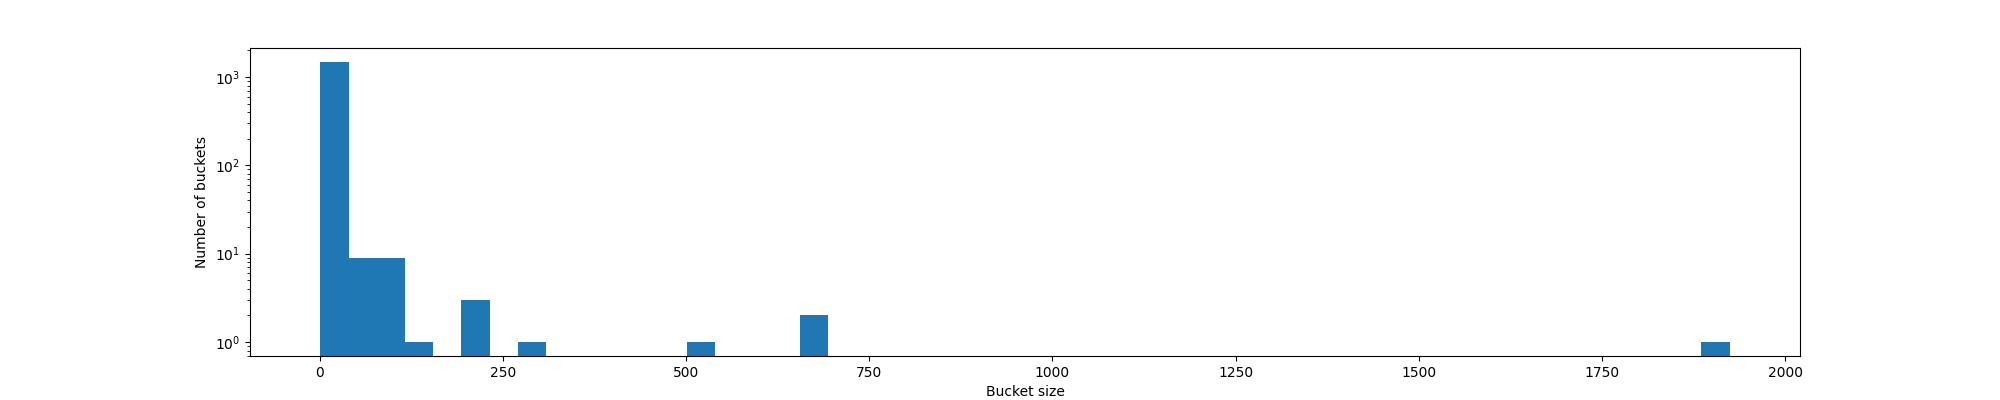

In [111]:
plt.clf()

plt.hist(bucket_sizes, min(50, max(bucket_sizes)))
plt.yscale('log')
plt.xlabel('Bucket size')
plt.ylabel('Number of buckets')
plt.show()

%matplot plt

### 3.4 Filter Buckets with at least Two Elements


If the number of singleton buckets was too large, we can remove them to speed up operations. Write code to construct an RDD (`fp_to_bucket_filtered`) that maps a fingerprint to a bucket of size greater than 1. Also, similar to above, compute the sizes of the filtered buckets (`bucket_sizes_filtered`).


In [112]:
# Filter out buckets that have only one element
fp_to_bucket_filtered = fp_to_bucket.filter(lambda kv: len(kv[1]) > 1)

# Compute the bucket sizes for the filtered buckets (as an RDD)
bucket_sizes_filtered = fp_to_bucket_filtered.map(lambda kv: len(kv[1]))

n_buckets_filtered = bucket_sizes_filtered.count()
print(f"Found {n_buckets_filtered} buckets with at least 2 data points.")

min_bucket_size = bucket_sizes_filtered.min()
max_bucket_size = bucket_sizes_filtered.max()

print(f"min={min_bucket_size}, max={max_bucket_size}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found 392 buckets with at least 2 data points.
min=2, max=1924

In [113]:
# Check that the minimum bucket size is > 1
assert_true(min_bucket_size > 1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 4. Analysis and Visualization


In [114]:
# We need this since we are hashing tuples which by default is not
# a deterministic operation in Python.
os.environ["PYTHONHASHSEED"] = str(42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.1 Implement Code to Map a Query Image to its Neighbors


Here, we write two convenience functions that 1) map an image identified by its ID to a fingerprint `fp` and 2) return all the images in the bucket identified by `fp`.


In [115]:
# We will be using them in the following two functions, so make
# sure to broadcast first.

image_rdd_fp_sorted_broadcast = sc.broadcast(
    image_rdd_fp.keyBy(lambda x: x.idx).sortByKey().collectAsMap()
)

fp_to_bucket_filtered_broadcast = sc.broadcast(
    fp_to_bucket_filtered.collectAsMap()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [116]:
def get_bucket_indices(fp):
    """Given a fingerprint, returns a list of indices corresponding
    to all the elements in that bucket.
    You can use fp_to_bucket_filtered_broadcast.

    Return an empty list if the fingerprint is not found.

    Parameters
    ----------
    fp: tuple of tuples
        The fingerprint.

    Returns
    -------
    List[int]
        The indices of images in this bucket.
    """
    # Get the bucket from the broadcast dictionary; default to an empty list if not found.
    bucket = fp_to_bucket_filtered_broadcast.value.get(fp, [])
    # Extract the 'idx' attribute from each row in the bucket.
    return [row.idx for row in bucket]

def get_hits(idx):
    """Given the ID of a single image, find the bucket it has
    been assigned to, and return a list of all other indices
    in that bucket. You can use image_rdd_fp_sorted_broadcast.

    HINT: Use get_bucket_indices defined above

    Parameters
    ----------
    idx: int
        The ID of the query image.

    Returns
    -------
    List[int]
        Indices of matching images (excluding the query image itself).
    """
    # Get the dictionary mapping image IDs to rows.
    image_dict = image_rdd_fp_sorted_broadcast.value
    # Look up the row corresponding to the given idx.
    if idx not in image_dict:
        return []
    fp = image_dict[idx].fp
    # Get all indices in the bucket corresponding to this fingerprint.
    bucket_indices = get_bucket_indices(fp)
    # Exclude the query image index.
    return [i for i in bucket_indices if i != idx]


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.2 Visualize LSH Neighbors




Finally, let us visualize some buckets. We provide two images in the cells below, a stegosaurus and a human face for demonstration. Feel free to test other images (you can find a full list of classes and filenames in the S3 bucket, link at the top), but make sure you **use the default two when submitting your notebook**.

The first image shown will always be the query image.


In [117]:
# sortByKey will make our lookups a lot faster.
# source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.lookup.html
# Cache because we will be using this a lot.
image_rdd_sorted = image_rdd.keyBy(lambda x: x.idx).sortByKey().cache()
# print(image_rdd_sorted.first())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
def plot_images(hits, cols=5):
    plt.clf()
    nrows = math.ceil(len(hits) / cols)
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(15, nrows*3))
    for row, ax in zip_longest(hits, axes.flat, fillvalue=None):
        if row is None:
            ax.remove()
            continue
        ax.imshow(np.asarray(row.image_lg).reshape(SHAPE))
        ax.set_title(f"label={row.label}, idx={row.idx}")
        ax.set_axis_off()
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

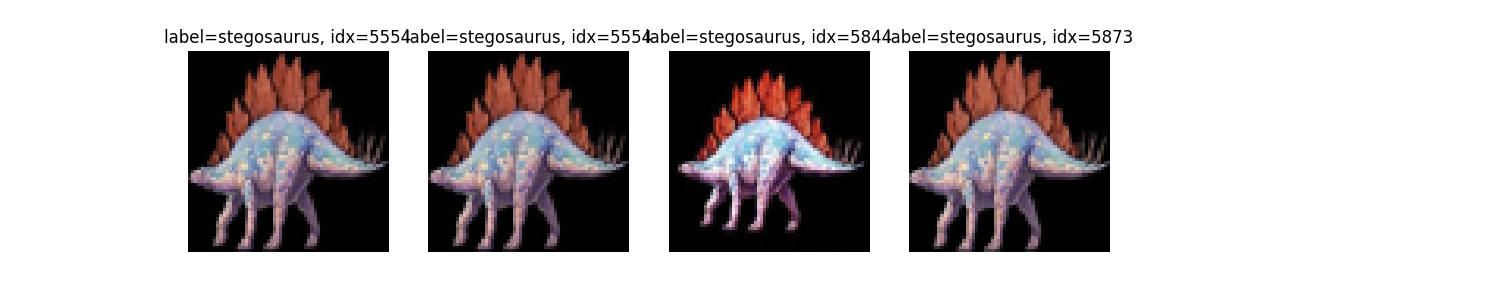

In [128]:
# NOTE: If you are using a subset of the data, this query
# may not be in that set and you may get an out of range error.

row1 = image_rdd.keyBy(lambda x: x.filename).lookup(
    'stegosaurus/image_0043.jpg'
)[0]
test_idx1 = row1.idx

hits_idx1 = get_hits(test_idx1)
print(f"Found {len(hits_idx1)} hits.")
if len(hits_idx1) == 0:
    prinT(2)
    raise ValueError(f"No hits were found for id {test_idx1}")

if len(hits_idx1) > 20:
    print("There are too many hits; plotting only 20.")

# move the query element to the first position

if test_idx1 in hits_idx1:
    print(1)
    hits_idx1.remove(test_idx1)
hits_idx1.insert(0, test_idx1)

#hits_idx1.insert(0, test_idx1)

plt.clf()
# Take only the top 20
hits = [image_rdd_sorted.lookup(idx)[0] for idx in islice(hits_idx1, 20)]
plot_images(hits)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

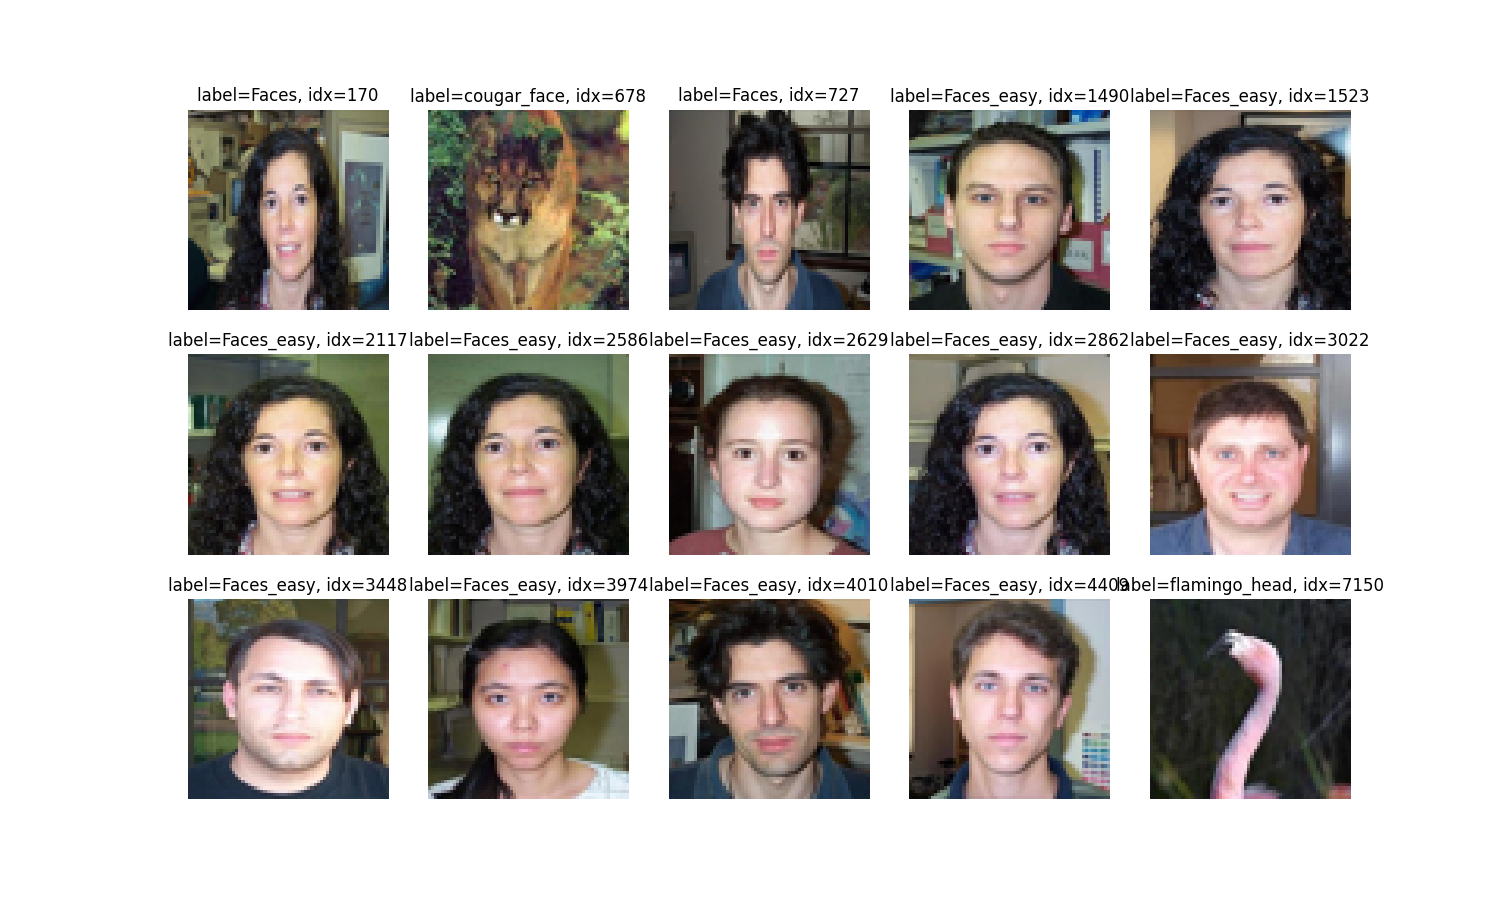

In [129]:
# NOTE: If you are using a subset of the data, this query
# may not be in that set and you may get an out of range error.
row2 = image_rdd.keyBy(lambda x: x.filename).lookup(
    'Faces/image_0334.jpg'
)[0]
test_idx2 = row2.idx

hits_idx2 = get_hits(test_idx2)
print(f"Found {len(hits_idx2)} hits.")
if len(hits_idx2) == 0:
    raise ValueError(f"No hits were found for id {test_idx2}")

if len(hits_idx2) > 20:
    print("There are too many hits; plotting only 20.")

# move the query element to the first position

if test_idx2 in hits_idx2:
    print(1)
    hits_idx2.remove(test_idx2)
hits_idx2.insert(0, test_idx2)

# Take only the top 20
hits2 = [image_rdd_sorted.lookup(idx)[0] for idx in islice(hits_idx2, 20)]
plot_images(hits2)

%matplot plt

## Part 5. Feature Extraction Using a Pre-Trained VGG


Now we will use a pretrained [VGG](https://arxiv.org/abs/1409.1556) neural network to compute approximate neighbors. We remove the top classification layer from our network, leaving the last fully-connected layer, as the new output layer. The features from this last 4096-neuron fully connected layer can be used as embeddings for our images. Since the neural network was trained to predict the correct class for each image, we expect these embeddings to be similar for image belonging to the same class. We will compute exact nearest neighbors on these embeddings and comapre the neighbors we get with the LSH neighbors. Since this can be expensive to compute for all pairs of points, we only do so for the query images above.

We extracted all the 4096-dimensional feature vectors for this dataset, so all we need to do is download them from the S3 bucket.


In [121]:
# This will download the VGG feature embeddings for
# each image in our dataset.
import boto3
import boto3.session

cred = boto3.Session().get_credentials()
s3client = boto3.client('s3')

response = s3client.get_object(
    Bucket='10-605spring2025',  # DO NOT change this name
    Key='caltech101_vgg_feats.pickle',
)

body = response['Body'].read()

data = pickle.loads(body)

# Example element
print('Example point', data[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Example point {'features': array([0.       , 2.62858  , 0.       , ..., 0.       , 1.0712367,
       0.       ], dtype=float32), 'path': './data/chair/image_0023.jpg'}

Here we make sure that each image is mapped to the right ID. Finally, all feature vectors are stacked into an array `X` of shape (n_samples, 4096).


In [122]:
# First map each path (category, filename) to that file's idx.
path_to_idx = image_rdd.map(lambda row: (row.filename, row.idx)).collectAsMap()

idx_to_features = {}
for item in data:
    # item['path'] is of the format './data/class/filename.jpg'
    path = item['path'].split('/', maxsplit=2)[-1]
    if path not in path_to_idx:
        # This only happens if we are using a subset of the data
        continue
    idx_to_features[path_to_idx[path]] = item['features']

idx_to_features = {k: idx_to_features[k] for k in sorted(idx_to_features)}

X = np.vstack(list(idx_to_features.values()))

print(f"Found {item['features'].size}-dimensional feature vectors.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found 4096-dimensional feature vectors.

In [123]:
assert_equal(len(path_to_idx), len(idx_to_features))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 5.1 Compute Neighbors based on VGG Embeddings


The following function, takes a query image ID, and computes its exact neighbors as measured by euclidean distance.


In [124]:
def get_exact_nn_indices(query_idx, k=20):
    """Returns the indices of the nearest k points in X.

    Parameters
    ----------
    query_idx: int
        The idx of the query image.
    k: int
        The number of nearest neighbors to return.

    Returns
    -------
    List[int] or array
        A list of integers representing the indices of the top kNN.
    """
    # Get the feature vector for the query image.
    query_feat = X[query_idx]
    
    # Compute Euclidean distances from the query feature to all features in X.
    distances = np.linalg.norm(X - query_feat, axis=1)
    
    # Get the indices of the k smallest distances.
    nn_indices = np.argsort(distances)[:k]
    
    return nn_indices

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 5.2 Compare VGG Neighbors with LSH Neighbors


Which method returns neighbors of higher quality?

When comparing the two methods, also take note of the runtime for both. In the LSH section, we computed fingerprints for all images and put them into buckets. In this section, we only computed exact neighbors for two query images.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

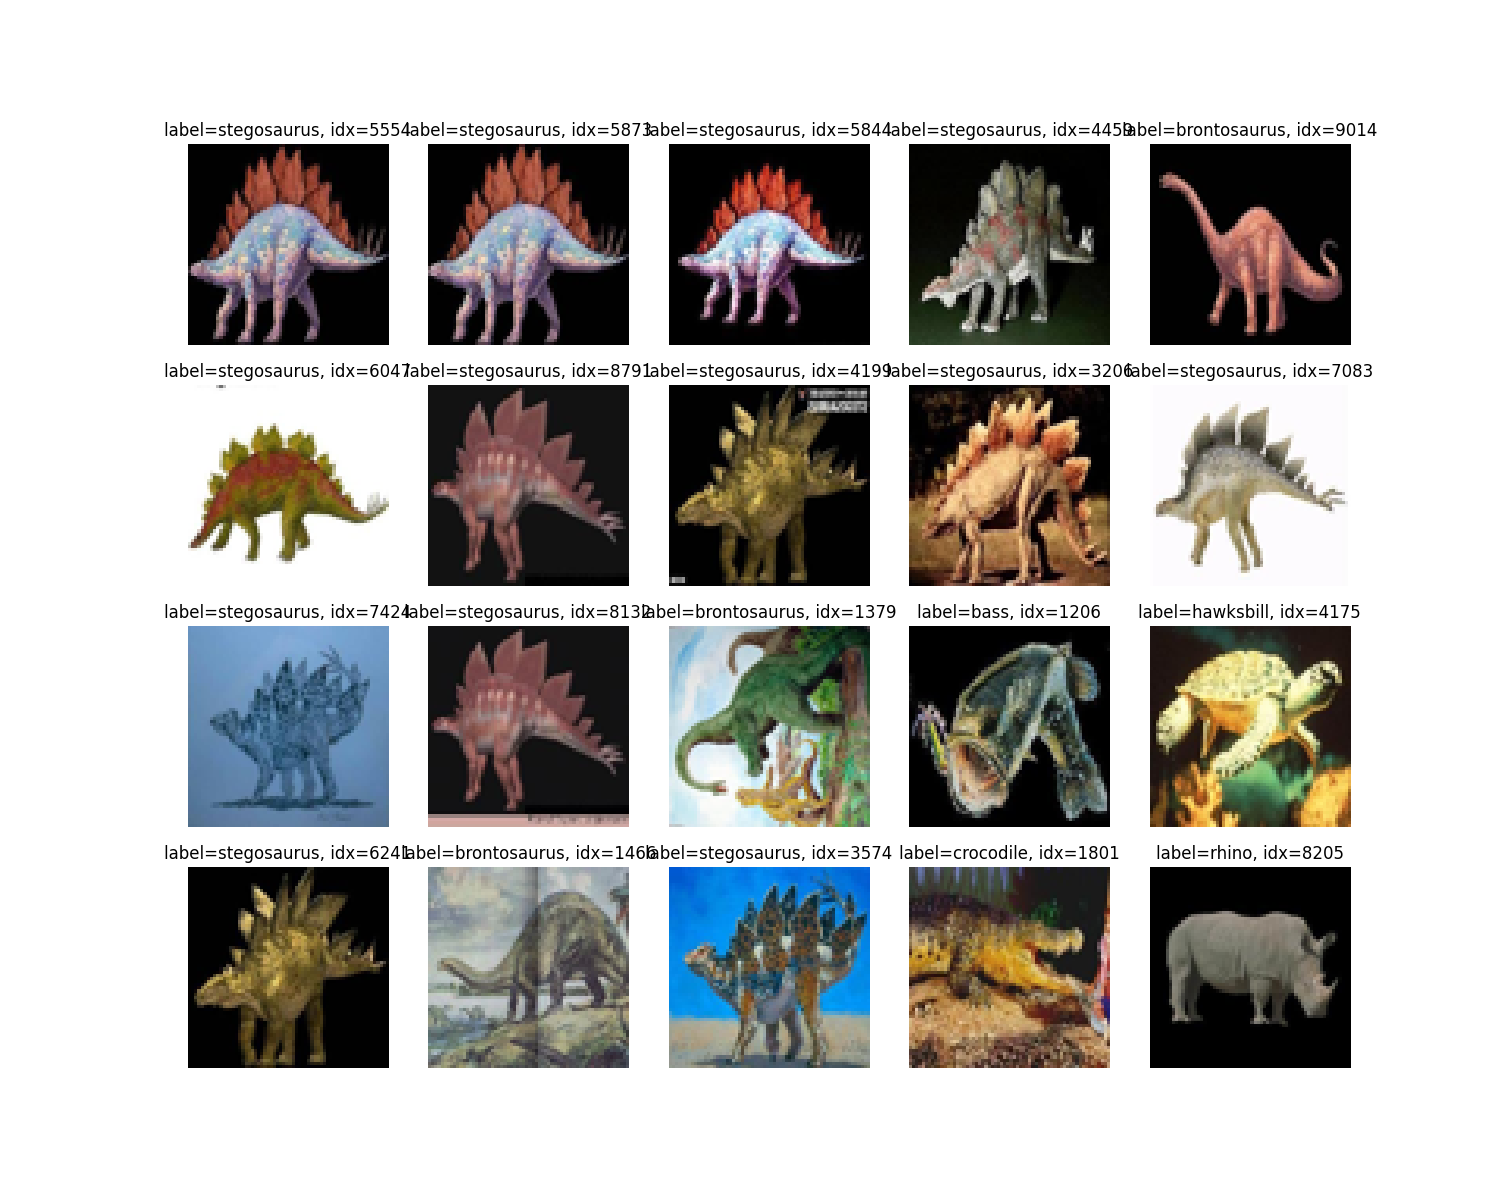

In [125]:
hits_idx = get_exact_nn_indices(test_idx1)
print(f"Found {len(hits_idx)} hits.")
if len(hits_idx) > 20:
    print("There are too many hits; plotting only 20.")
elif len(hits_idx) == 0:
    raise ValueError(f"No hits were found for id {idx}")
else:
    # Take only the top 20
    hits = [image_rdd_sorted.lookup(idx)[0] for idx in islice(hits_idx, 20)]
    plot_images(hits)

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

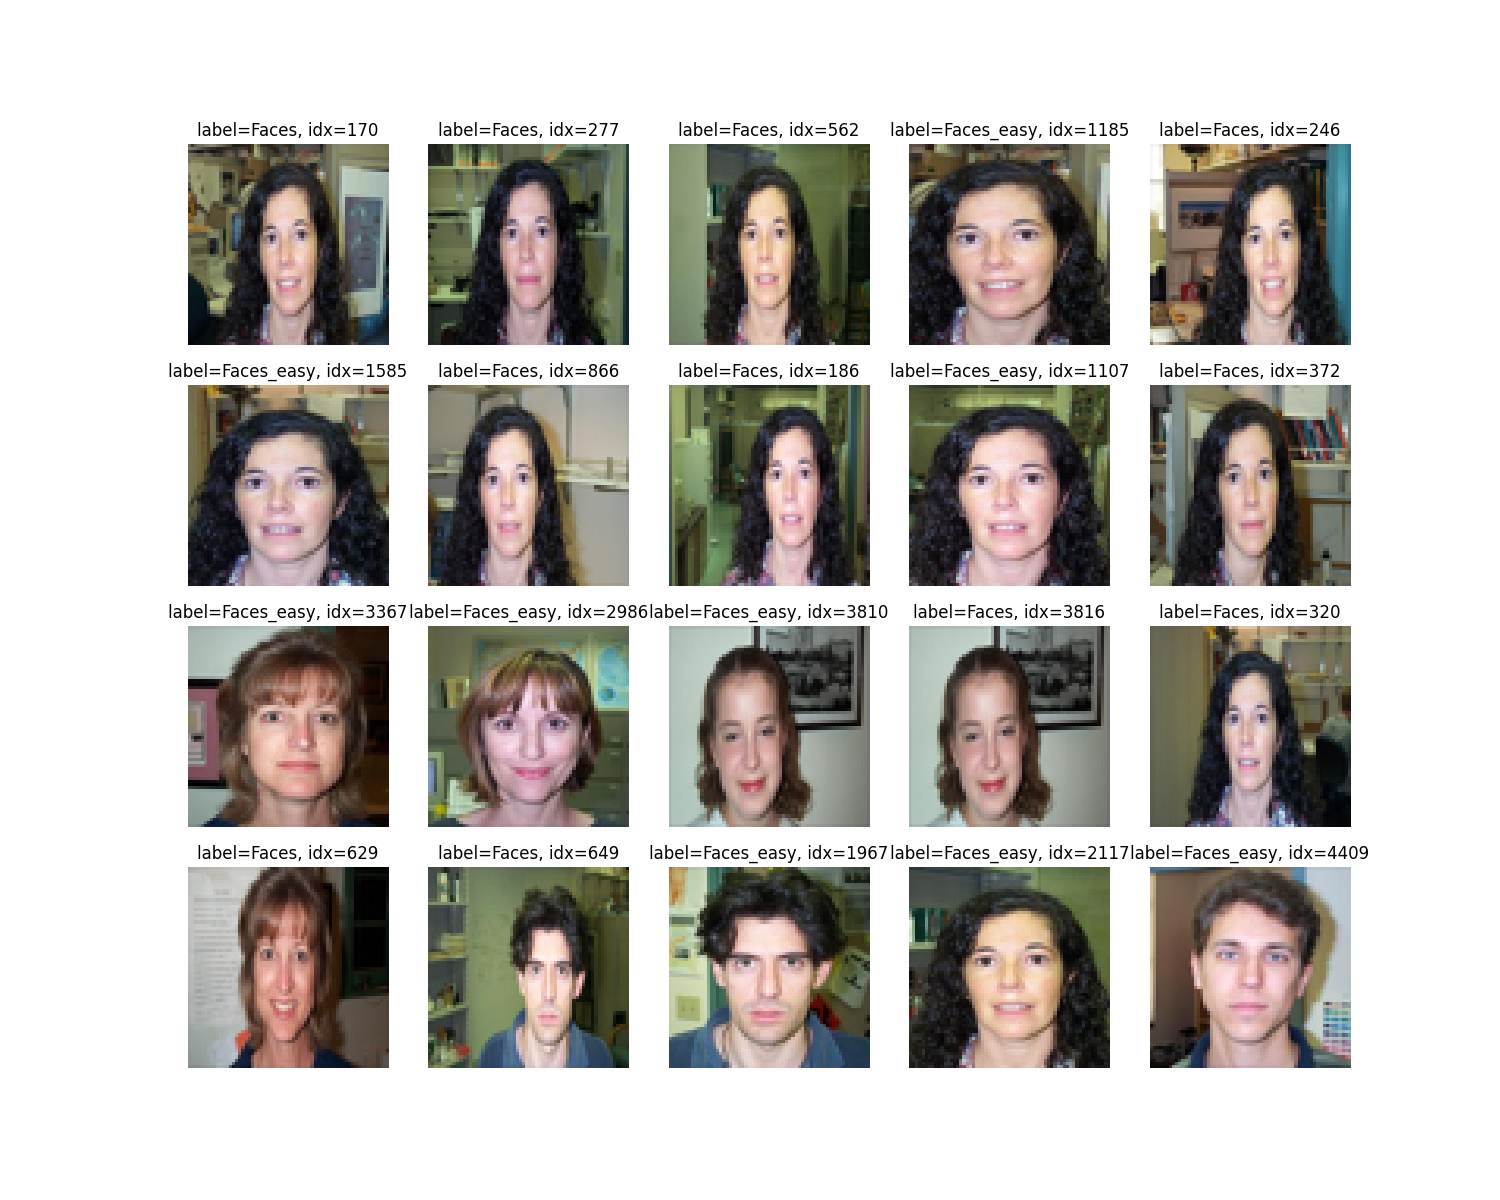

In [126]:
hits_idx2 = get_exact_nn_indices(test_idx2)
print(f"Found {len(hits_idx2)} hits.")
if len(hits_idx2) > 20:
    print("There are too many hits; plotting only 20.")
elif len(hits_idx2) == 0:
    raise ValueError(f"No hits were found for id {test_idx2}")
else:
    # Take only the top 20
    hits2 = [image_rdd_sorted.lookup(idx)[0] for idx in islice(hits_idx2, 20)]
    plot_images(hits2)

%matplot plt